In [1]:
import warnings
import os
from PIL import Image
import math
import numpy as np
import csv

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import vgg19, VGG19_Weights, inception_v3, Inception_V3_Weights
from torchvision.models.feature_extraction import create_feature_extractor

from scipy.linalg import sqrtm

from skimage.metrics import structural_similarity as ssim

import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")


In [6]:
class SketchyDataset(Dataset):
    def __init__(self, image_dir, sketch_dir, photo_transform=None, sketch_transform=None,
                 use_bbox=False, stats_file='sketchy_dataset/info/stats.csv'):
        self.image_dir = image_dir
        self.sketch_dir = sketch_dir
        self.photo_transform = photo_transform
        self.sketch_transform = sketch_transform
        self.use_bbox = use_bbox

        # Load metadata from stats.csv for bounding boxes and invalid sketches
        self.bboxes = {}           # Maps photo ImageNetID to (left, top, right, bottom) for cropping
        self.invalid_sketches = set()  # Set of invalid sketch IDs (format: "ImageNetID-SketchID")&#8203;:contentReference[oaicite:3]{index=3}

        # Parse stats.csv to populate bboxes and invalid_sketches
        with open(stats_file, 'r') as csvfile:
            reader = csv.reader(csvfile)
            header = next(reader)  # skip header line
            for row in reader:
                # If a WorkerTag contains commas, merge extra columns into the last field
                if len(row) > 23:
                    row = row[:22] + [",".join(row[22:])]
                photo_id = row[2]    # e.g., "n02691156_11257"
                sketch_no = row[3]   # e.g., "1", "2", etc.
                # Check validity flags (Error, Context, Ambiguous, WrongPose)&#8203;:contentReference[oaicite:4]{index=4}
                if row[18] == '1' or row[19] == '1' or row[20] == '1' or row[21] == '1':
                    sketch_id = f"{photo_id}-{sketch_no}"
                    self.invalid_sketches.add(sketch_id)
                # Compute and store bounding box (scaled to 256x256) if needed
                if use_bbox and photo_id not in self.bboxes:
                    orig_w = float(row[12]); orig_h = float(row[13])
                    bx = float(row[14]); by = float(row[15]); bw = float(row[16]); bh = float(row[17])
                    # Scale bounding box to match the 256x256 resized photo dimensions&#8203;:contentReference[oaicite:5]{index=5}
                    scale_x = 256.0 / orig_w if orig_w > 0 else 1.0
                    scale_y = 256.0 / orig_h if orig_h > 0 else 1.0
                    left   = math.floor(bx * scale_x)
                    top    = math.floor(by * scale_y)
                    right  = math.ceil((bx + bw) * scale_x)
                    bottom = math.ceil((by + bh) * scale_y)
                    # Clamp to valid image bounds [0, 255]
                    right  = min(right, 255)
                    bottom = min(bottom, 255)
                    self.bboxes[photo_id] = (left, top, right, bottom)

        # Prepare list of sketch-photo pairs and compute per-category stats
        self.pairs = []
        self.photo_means = {}
        self.photo_stds  = {}
        self.sketch_means = {}
        self.sketch_stds  = {}
        categories = [d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))]
        categories_to_keep = []

        for category in categories:
            photo_dir = os.path.join(image_dir, category)
            sketch_dir_cat = os.path.join(sketch_dir, category)
            if not os.path.exists(photo_dir) or not os.path.exists(sketch_dir_cat):
                continue  # skip if either folder is missing
            # Initialize accumulators for this category
            photo_sum = np.zeros(3, dtype=np.float64)
            photo_sq_sum = np.zeros(3, dtype=np.float64)
            sketch_sum = np.zeros(3, dtype=np.float64)
            sketch_sq_sum = np.zeros(3, dtype=np.float64)
            photo_count = 0
            sketch_count = 0

            # Iterate over all photos in the category directory
            for photo_file in os.listdir(photo_dir):
                if not photo_file.lower().endswith(('.jpg', '.png')):
                    continue
                photo_id = os.path.splitext(photo_file)[0]
                # Use naming format to find matching sketches&#8203;:contentReference[oaicite:6]{index=6}
                # (If photo_id already contains a '-', it's a stable diffusion image corresponding to one sketch)
                prefix = photo_id + '-' if '-' not in photo_id else photo_id
                sketch_files = [f for f in os.listdir(sketch_dir_cat)
                                if f.lower().endswith(('.jpg', '.png')) and f.startswith(prefix)]
                # Filter out invalid sketches for this photo
                valid_sketches = [f for f in sketch_files if os.path.splitext(f)[0] not in self.invalid_sketches]
                if len(valid_sketches) == 0:
                    continue  # no valid sketches for this photo
                # Process this photo (since it has at least one valid sketch)
                photo_path = os.path.join(photo_dir, photo_file)
                # Accumulate photo pixel stats (in 0-1 range)
                img = Image.open(photo_path).convert('RGB')
                img_arr = np.array(img, dtype=np.float32) / 255.0
                photo_sum    += img_arr.sum(axis=(0, 1))
                photo_sq_sum += (img_arr ** 2).sum(axis=(0, 1))
                photo_count  += 1
                # Process each valid sketch for this photo
                for sketch_file in valid_sketches:
                    sketch_path = os.path.join(sketch_dir_cat, sketch_file)
                    sk_img = Image.open(sketch_path).convert('RGB')
                    sk_arr = np.array(sk_img, dtype=np.float32) / 255.0
                    sketch_sum    += sk_arr.sum(axis=(0, 1))
                    sketch_sq_sum += (sk_arr ** 2).sum(axis=(0, 1))
                    sketch_count  += 1
                    # Store the valid pair
                    self.pairs.append({
                        'category': category,
                        'photo': photo_path,
                        'sketch': sketch_path
                    })
            # Compute mean and std for this category (if any valid pairs exist)
            if photo_count > 0 and sketch_count > 0:
                # Mean per channel
                photo_mean = photo_sum / (photo_count * 256 * 256)
                sketch_mean = sketch_sum / (sketch_count * 256 * 256)
                # Variance per channel
                photo_var = (photo_sq_sum / (photo_count * 256 * 256)) - (photo_mean ** 2)
                sketch_var = (sketch_sq_sum / (sketch_count * 256 * 256)) - (sketch_mean ** 2)
                photo_var = np.clip(photo_var, 0, None)   # avoid negative due to floating error
                sketch_var = np.clip(sketch_var, 0, None)
                photo_std = np.sqrt(photo_var)
                sketch_std = np.sqrt(sketch_var)
                # Store stats (as Python lists for later normalization)
                self.photo_means[category]  = photo_mean.tolist()
                self.photo_stds[category]   = photo_std.tolist()
                self.sketch_means[category] = sketch_mean.tolist()
                self.sketch_stds[category]  = sketch_std.tolist()
                categories_to_keep.append(category)
        # Keep only categories that have valid pairs
        self.categories = categories_to_keep

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        category = pair['category']
        # Load images
        photo = Image.open(pair['photo']).convert('RGB')
        sketch = Image.open(pair['sketch']).convert('RGB')
        # Crop photo to bounding box if enabled (only for original photos)
        if self.use_bbox:
            photo_id = os.path.splitext(os.path.basename(pair['photo']))[0]
            if photo_id in self.bboxes:
                left, top, right, bottom = self.bboxes[photo_id]
                photo = photo.crop((left, top, right, bottom))
                # Resize back to 256x256 to maintain consistent dimensions
                photo = photo.resize((256, 256), Image.BILINEAR)
        # Apply any additional (non-normalization) transforms
        if self.photo_transform:
            photo = self.photo_transform(photo)
        if self.sketch_transform:
            sketch = self.sketch_transform(sketch)
        # Convert to tensor if not already
        if not isinstance(photo, torch.Tensor):
            photo = transforms.functional.to_tensor(photo)
        if not isinstance(sketch, torch.Tensor):
            sketch = transforms.functional.to_tensor(sketch)
        # Normalize using the precomputed mean and std for this category
        if category in self.photo_means and category in self.photo_stds:
            photo = transforms.functional.normalize(photo, mean=self.photo_means[category], std=self.photo_stds[category])
        if category in self.sketch_means and category in self.sketch_stds:
            sketch = transforms.functional.normalize(sketch, mean=self.sketch_means[category], std=self.sketch_stds[category])
        return {
            'sketch': sketch,
            'photo': photo,
            'category': category,
            'sketch_path': pair['sketch'],
            'photo_path': pair['photo']
        }


In [7]:
dataset = SketchyDataset(
    image_dir='sketchy_dataset/photo/tx_000000000000',  # Photos with `tx_000000000000` transformation
    sketch_dir='sketchy_dataset/sketch/tx_000000000000',  # Corresponding sketches with `tx_000000000000` transformation
    use_bbox=True,                    # enable cropping to bounding box
)

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


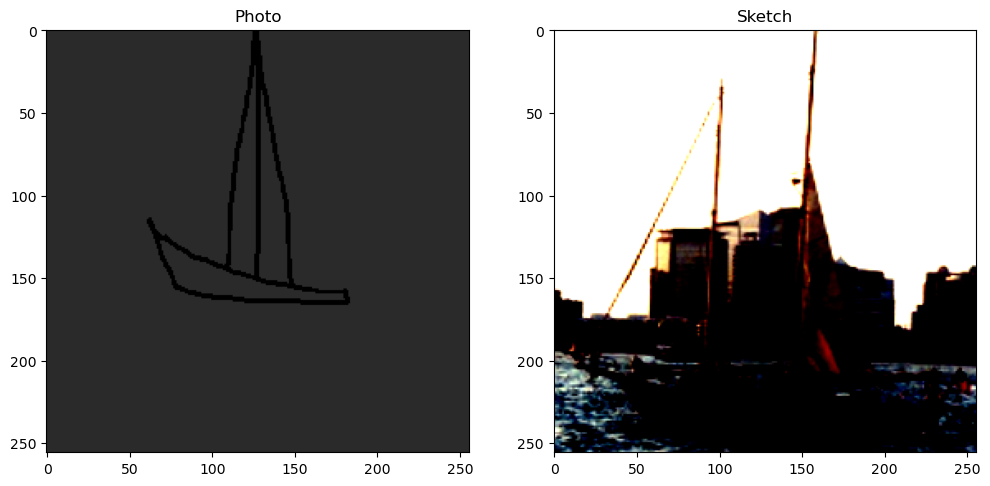

In [8]:
# Fetch the first batch
batch = next(iter(dataloader))

# Display a sample photo and its corresponding sketch
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Access the first photo and sketch in the batch
photo = batch['photo'][0].clamp(0, 1).permute(1, 2, 0).numpy()  # Display photo
sketch = batch['sketch'][0].clamp(0, 1).permute(1, 2, 0).numpy()  # Display sketch

# Plotting the photo and sketch side-by-side
ax[0].imshow(sketch)
ax[0].set_title("Photo")

ax[1].imshow(photo)
ax[1].set_title("Sketch")

plt.show()


In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Encoder: Downsample
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Decoder: Upsample
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x1 = self.encoder(x)
        return self.decoder(x1)


In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # PatchGAN: Classifies patches of the image as real or fake
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)  # Output a single value (real/fake)
        )

    def forward(self, x):
        return self.model(x)


In [8]:
class GANLoss(nn.Module):
    def __init__(self, gan_type='bce'):
        super(GANLoss, self).__init__()
        if gan_type == 'bce':
            self.criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy loss

    def forward(self, logits, target):
        return self.criterion(logits, target)


In [9]:
class PerceptualLoss(nn.Module):
    def __init__(self, model):
        super(PerceptualLoss, self).__init__()
        self.model = model.features.to(device).eval()

    def forward(self, generated, real):
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        generated_features = self.model(normalize(generated))
        real_features = self.model(normalize(real))
        return F.mse_loss(generated_features, real_features)


In [10]:
def compute_psnr(generated, real):
    mse = F.mse_loss(generated, real)  # Mean Squared Error
    return 20 * torch.log10(1.0 / torch.sqrt(mse))  # Formula for PSNR


In [11]:
def compute_ssim(generated, real, win_size=7):
    # Move channels to the last dimension, and convert to numpy
    gen_np = generated.cpu().numpy().transpose(1, 2, 0)
    real_np = real.cpu().numpy().transpose(1, 2, 0)

    # Both arrays should be in [0,1] range already
    # Compute SSIM, telling it that axis=2 is the channel axis
    ssim_value = ssim(
        gen_np,
        real_np,
        win_size=win_size,
        channel_axis=2,
        data_range=1.0
    )
    return ssim_value


In [12]:
warnings.filterwarnings(
    "ignore",
    "NOTE: The nodes obtained by tracing the model in eval mode are a subsequence"
)

# 1) Build a feature-extractor that returns the 2048-d avgpool output
def get_inception_extractor():
    inception = inception_v3(weights=Inception_V3_Weights.DEFAULT).to(device)
    inception.eval()
    return create_feature_extractor(
        inception,
        return_nodes={'avgpool': 'feat'},
    )

# 2) Extract features from a batch of tensors [N,3,256,256] in [-1,1]
def extract_features(x, extractor):
    # x: [N,3,256,256] in [-1,1]
    x = (x * 0.5) + 0.5
    x = F.interpolate(x, size=(299,299), mode='bilinear', align_corners=False)
    mean = torch.tensor([0.485,0.456,0.406], device=device).view(1,3,1,1)
    std  = torch.tensor([0.229,0.224,0.225], device=device).view(1,3,1,1)
    x = (x - mean) / std

    with torch.no_grad():
        out = extractor(x)['feat']  # [N,2048,1,1]
    return out.view(out.size(0), -1).cpu().numpy()  # [N,2048]

# 3) Compute FID from two batches of images
def compute_fid(real_images, generated_images):
    # Build extractor once
    extractor = get_inception_extractor()

    real_feats = extract_features(real_images, extractor)
    fake_feats = extract_features(generated_images, extractor)

    mu_r, mu_f = real_feats.mean(0), fake_feats.mean(0)
    sigma_r = np.cov(real_feats, rowvar=False)
    sigma_f = np.cov(fake_feats, rowvar=False)

    diff = mu_r - mu_f
    covmean, _ = sqrtm(sigma_r.dot(sigma_f), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma_r + sigma_f - 2 * covmean)
    return float(fid)


In [13]:
def init():
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    gan_loss = GANLoss().to(device)
    perceptual_loss = PerceptualLoss(vgg19(weights=VGG19_Weights.DEFAULT)).to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

    return generator, discriminator, gan_loss, perceptual_loss, optimizer_G, optimizer_D


In [14]:
num_epochs = 60  # Set the number of epochs you want to train for
output_height = output_width = 255 // 16


In [15]:
def train(generator, discriminator, gan_loss, perceptual_loss, optimizer_G, optimizer_D, num_epochs=50, steps=10, adv=1, l1=100, perc=0.02):
    for epoch in range(num_epochs):
        for i, batch in enumerate(dataloader):
            sketches = batch['sketch'].to(device)
            photos = batch['photo'].to(device)

            # Train Discriminator
            optimizer_D.zero_grad()

            real_labels = torch.ones(sketches.size(0), 1, output_height, output_width).to(device)
            fake_labels = torch.zeros(sketches.size(0), 1, output_height, output_width).to(device)

            # Real images
            real_output = discriminator(torch.cat((sketches, photos), 1))
            d_loss_real = gan_loss(real_output, real_labels)

            # Fake images
            fake_photos = generator(sketches)
            fake_output = discriminator(torch.cat((sketches, fake_photos.detach()), 1))
            d_loss_fake = gan_loss(fake_output, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()

            fake_output = discriminator(torch.cat((sketches, fake_photos), 1))
            g_loss = adv * gan_loss(fake_output, real_labels) + l1 * F.l1_loss(fake_photos, photos) + perc * perceptual_loss(fake_photos, photos)

            g_loss.backward()
            optimizer_G.step()

        # Print and save model checkpoints
        print(f'Epoch [{epoch + 1}/{num_epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

        # Monitor training progress: Visualize generated images and calculate metrics
        if epoch == 0 or (epoch + 1) % steps == 0:
            torch.save(generator.state_dict(), f"generator_epoch_{epoch}.pth")
            torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch}.pth")

            with torch.no_grad():
                generated_images = generator(sketches)
                # Denormalize if needed
                generated_images = generated_images * 0.5 + 0.5
                photos = photos * 0.5 + 0.5

            psnr_value = compute_psnr(generated_images, photos)
            ssim_value = compute_ssim(generated_images[0], photos[0])
            fid_value = compute_fid(photos, generated_images)

            print(f'Epoch [{epoch + 1}/{num_epochs}], PSNR: {psnr_value.item()}, SSIM: {ssim_value}, FID: {fid_value}')

            # Plot real vs generated images
            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            ax[0].imshow(photos[0].cpu().permute(1, 2, 0).numpy())
            ax[0].set_title("Real Photo")
            ax[1].imshow(generated_images[0].cpu().permute(1, 2, 0).numpy())
            ax[1].set_title("Generated Photo")
            plt.show()


In [16]:
# for loss_perc in [0.05, 0.08, 0.10, 0.12]:
#     for loss_L1 in [100, 75, 50, 25]:
#         generator, discriminator, gan_loss, perceptual_loss, optimizer_G, optimizer_D = init()
#         train(generator, discriminator, gan_loss, perceptual_loss, optimizer_G, optimizer_D, num_epochs=10, steps=10, adv=1.0, l1=loss_L1, perc=loss_perc)


Epoch [1/60], D Loss: 0.8983131647109985, G Loss: 30.003087997436523
Epoch [1/60], PSNR: 9.485286712646484, SSIM: 0.10060197860002518, FID: 330.06461054862723


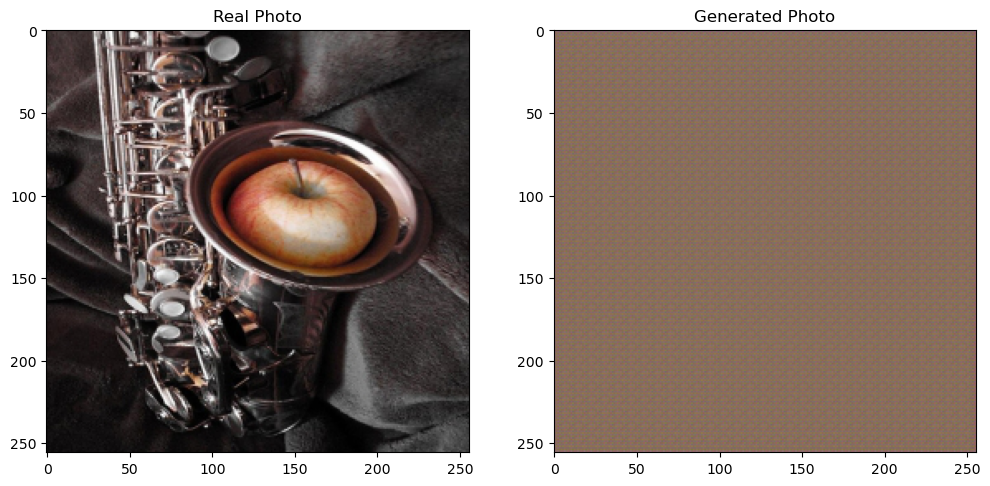

Epoch [2/60], D Loss: 0.3165581226348877, G Loss: 29.15454864501953
Epoch [3/60], D Loss: 0.10300134122371674, G Loss: 30.7933406829834
Epoch [4/60], D Loss: 0.5948102474212646, G Loss: 31.08147430419922
Epoch [5/60], D Loss: 1.576141119003296, G Loss: 28.328237533569336
Epoch [6/60], D Loss: 0.629034161567688, G Loss: 25.51399803161621
Epoch [7/60], D Loss: 0.9090819954872131, G Loss: 23.380863189697266
Epoch [8/60], D Loss: 1.1121296882629395, G Loss: 24.074411392211914
Epoch [9/60], D Loss: 1.2096126079559326, G Loss: 19.833744049072266
Epoch [10/60], D Loss: 0.8361738920211792, G Loss: 17.916828155517578
Epoch [10/60], PSNR: 13.58985424041748, SSIM: 0.28775885701179504, FID: 314.5795775408219


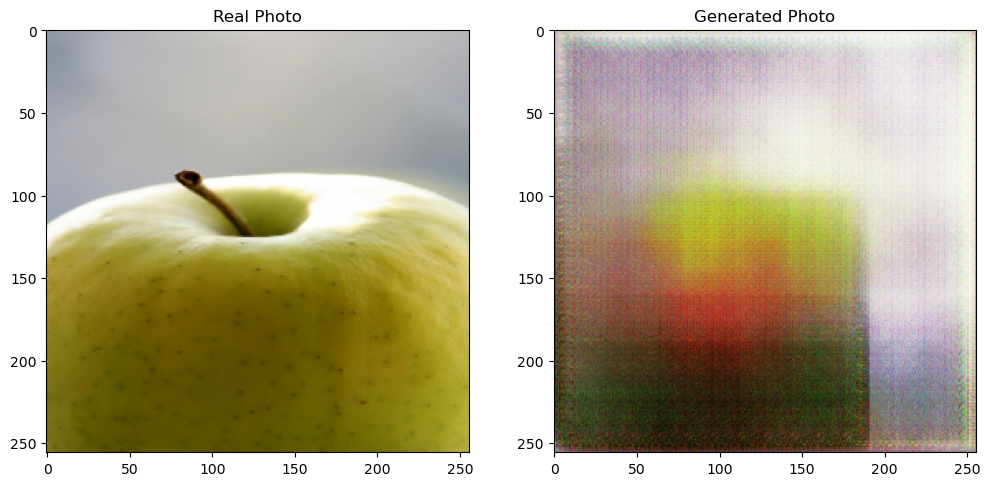

Epoch [11/60], D Loss: 0.9643875956535339, G Loss: 16.98519515991211
Epoch [12/60], D Loss: 1.174498438835144, G Loss: 15.866479873657227
Epoch [13/60], D Loss: 1.0937628746032715, G Loss: 16.93015480041504
Epoch [14/60], D Loss: 1.1406946182250977, G Loss: 14.88259220123291
Epoch [15/60], D Loss: 1.0836890935897827, G Loss: 15.948244094848633
Epoch [16/60], D Loss: 1.1423581838607788, G Loss: 14.354299545288086
Epoch [17/60], D Loss: 1.1241869926452637, G Loss: 15.703828811645508
Epoch [18/60], D Loss: 1.4080653190612793, G Loss: 13.541874885559082
Epoch [19/60], D Loss: 1.3384207487106323, G Loss: 13.308911323547363
Epoch [20/60], D Loss: 0.6618888974189758, G Loss: 11.773277282714844
Epoch [20/60], PSNR: 16.711057662963867, SSIM: 0.3396957814693451, FID: 279.1653473855798


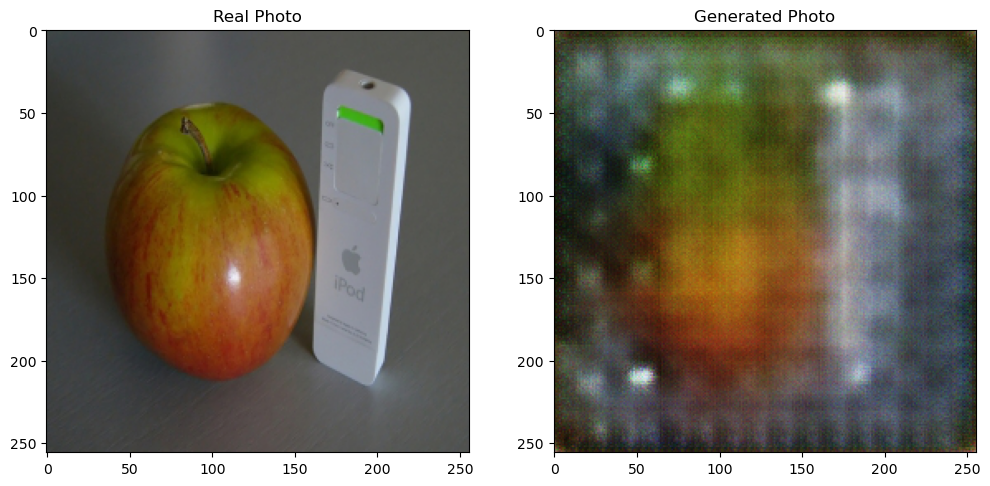

Epoch [21/60], D Loss: 1.0754472017288208, G Loss: 11.52568531036377
Epoch [22/60], D Loss: 1.4329266548156738, G Loss: 11.672961235046387
Epoch [23/60], D Loss: 1.0546820163726807, G Loss: 10.099359512329102
Epoch [24/60], D Loss: 1.3693945407867432, G Loss: 11.232704162597656
Epoch [25/60], D Loss: 1.1197359561920166, G Loss: 10.68925952911377
Epoch [26/60], D Loss: 1.1399810314178467, G Loss: 11.251984596252441
Epoch [27/60], D Loss: 1.4185798168182373, G Loss: 9.220612525939941
Epoch [28/60], D Loss: 0.9566138982772827, G Loss: 10.54246711730957
Epoch [29/60], D Loss: 1.1436192989349365, G Loss: 9.887847900390625
Epoch [30/60], D Loss: 1.2559305429458618, G Loss: 7.888669967651367
Epoch [30/60], PSNR: 19.660799026489258, SSIM: 0.4058466851711273, FID: 264.31844480275146


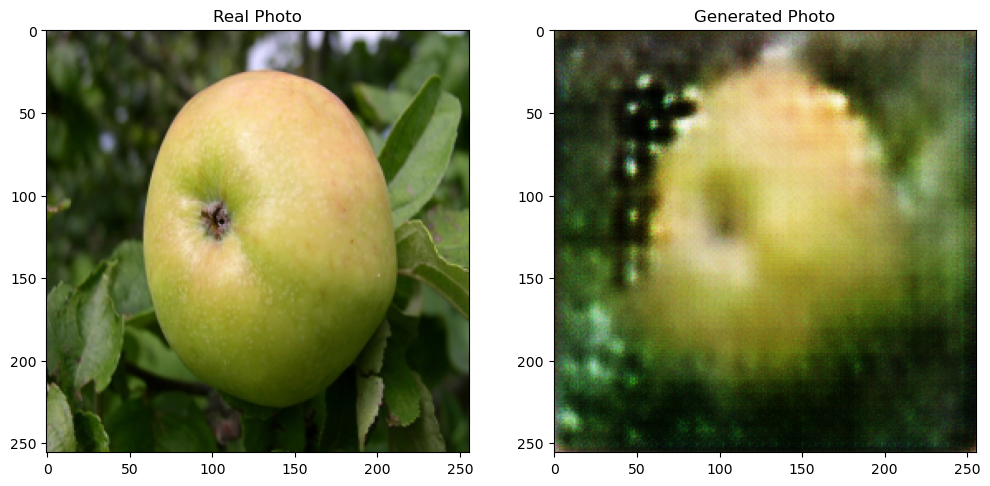

Epoch [31/60], D Loss: 1.1980557441711426, G Loss: 9.552778244018555
Epoch [32/60], D Loss: 1.3539793491363525, G Loss: 8.004373550415039
Epoch [33/60], D Loss: 1.5331698656082153, G Loss: 9.294095993041992
Epoch [34/60], D Loss: 1.2144355773925781, G Loss: 8.424269676208496
Epoch [35/60], D Loss: 1.3218984603881836, G Loss: 9.296798706054688
Epoch [36/60], D Loss: 1.1275607347488403, G Loss: 8.777498245239258
Epoch [37/60], D Loss: 1.371596336364746, G Loss: 10.579259872436523
Epoch [38/60], D Loss: 1.1460241079330444, G Loss: 7.95195198059082
Epoch [39/60], D Loss: 1.0325987339019775, G Loss: 8.229547500610352
Epoch [40/60], D Loss: 1.3905761241912842, G Loss: 7.837870121002197
Epoch [40/60], PSNR: 20.785837173461914, SSIM: 0.7438440322875977, FID: 255.64144214009596


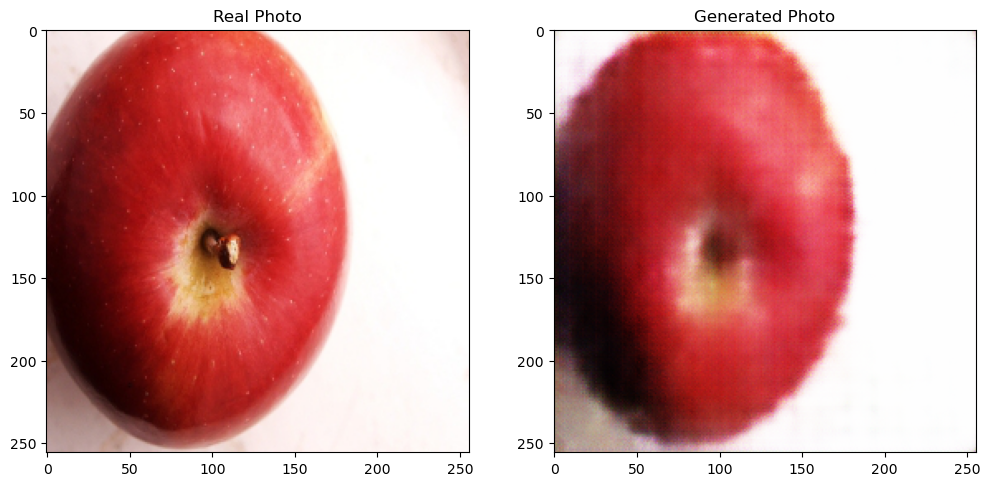

Epoch [41/60], D Loss: 1.0853099822998047, G Loss: 7.805873870849609
Epoch [42/60], D Loss: 1.3631709814071655, G Loss: 8.718900680541992
Epoch [43/60], D Loss: 1.1082631349563599, G Loss: 7.221831798553467
Epoch [44/60], D Loss: 1.183335542678833, G Loss: 8.005195617675781
Epoch [45/60], D Loss: 1.2755330801010132, G Loss: 7.3364033699035645
Epoch [46/60], D Loss: 1.174119234085083, G Loss: 8.068425178527832
Epoch [47/60], D Loss: 1.4265607595443726, G Loss: 9.032825469970703
Epoch [48/60], D Loss: 1.2833528518676758, G Loss: 6.647623062133789
Epoch [49/60], D Loss: 1.464490294456482, G Loss: 7.807376384735107
Epoch [50/60], D Loss: 1.1160304546356201, G Loss: 7.7705183029174805
Epoch [50/60], PSNR: 19.893085479736328, SSIM: 0.5553054213523865, FID: 306.630803669764


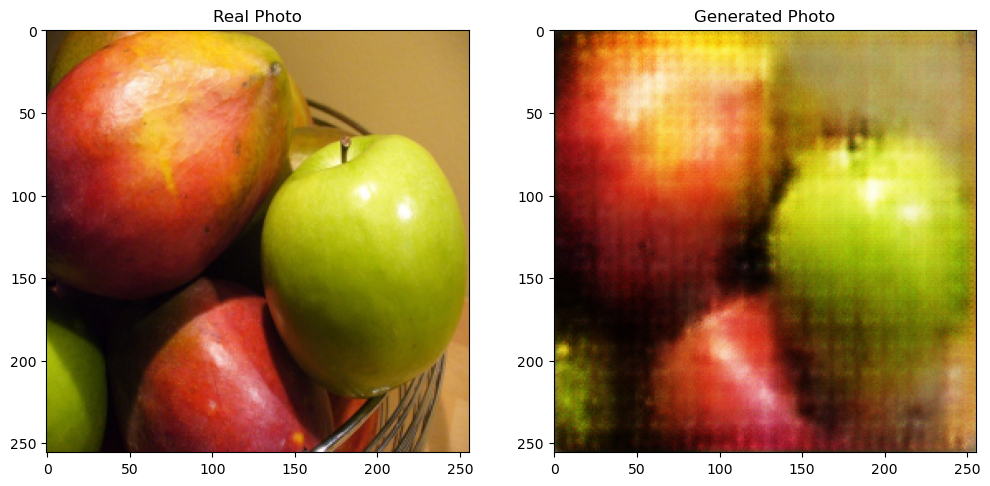

Epoch [51/60], D Loss: 1.1635737419128418, G Loss: 7.65887975692749
Epoch [52/60], D Loss: 1.1911559104919434, G Loss: 6.214578628540039
Epoch [53/60], D Loss: 1.231917381286621, G Loss: 7.111818790435791
Epoch [54/60], D Loss: 1.2509775161743164, G Loss: 6.549286365509033
Epoch [55/60], D Loss: 1.8806489706039429, G Loss: 6.710041046142578
Epoch [56/60], D Loss: 1.2521648406982422, G Loss: 7.095146656036377
Epoch [57/60], D Loss: 1.2575433254241943, G Loss: 6.47104549407959
Epoch [58/60], D Loss: 1.1407337188720703, G Loss: 6.323603630065918
Epoch [59/60], D Loss: 0.9968323707580566, G Loss: 6.896679401397705
Epoch [60/60], D Loss: 1.1689977645874023, G Loss: 7.152774810791016
Epoch [60/60], PSNR: 21.011253356933594, SSIM: 0.7007060050964355, FID: 257.2712839420185


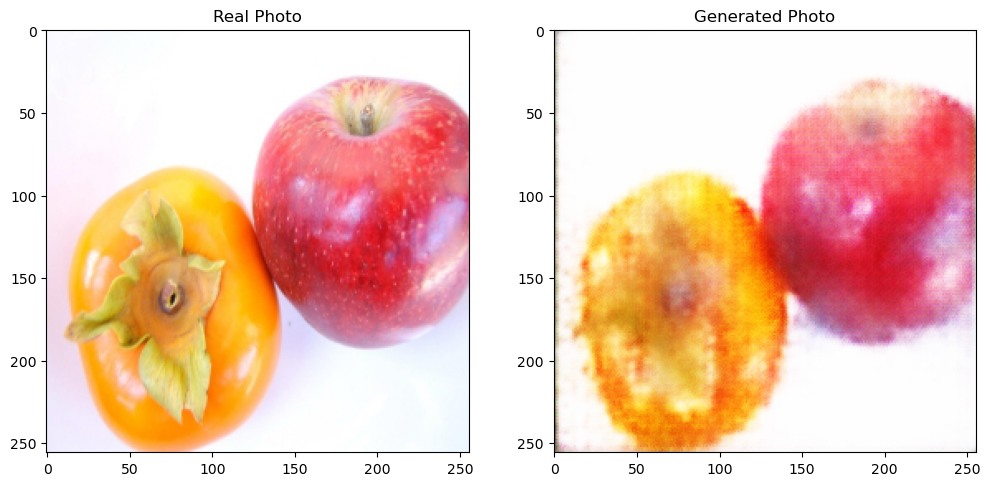

In [17]:
generator, discriminator, gan_loss, perceptual_loss, optimizer_G, optimizer_D = init()
train(generator, discriminator, gan_loss, perceptual_loss, optimizer_G, optimizer_D, num_epochs=num_epochs, l1=50, perc=0.1)


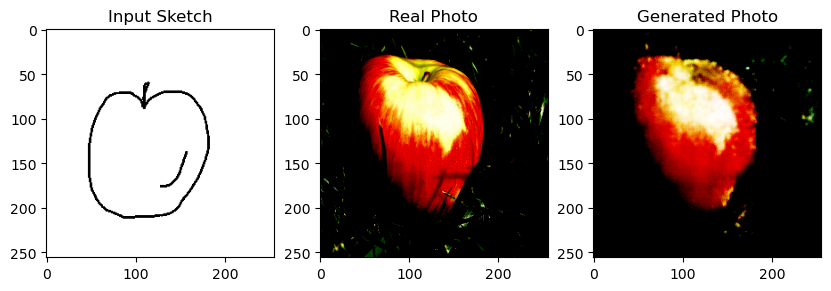

In [18]:
# Fetch a sample from the validation set
sample = next(iter(dataloader))

# Generate fake images
generated_images = generator(sample['sketch'].to(device))

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(sample['sketch'][0].clamp(0, 1).permute(1, 2, 0).numpy())
plt.title("Input Sketch")
plt.subplot(1, 3, 2)
plt.imshow(sample['photo'][0].clamp(0, 1).permute(1, 2, 0).numpy())
plt.title("Real Photo")
plt.subplot(1, 3, 3)
plt.imshow(generated_images[0].clamp(0, 1).cpu().permute(1, 2, 0).detach().numpy())
plt.title("Generated Photo")
plt.show()
